In [1]:
#import libraries
import pandas as pd
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#Load the data
Loyalty_points = pd.read_excel('C:\\Users\\Admin\\Downloads\\2022-Case-challenge_-DA-update-1.xlsx',sheet_name=1,engine='openpyxl')
Loyalty_benefits = pd.read_excel('C:\\Users\\Admin\\Downloads\\2022-Case-challenge_-DA-update-1.xlsx',sheet_name=2,engine='openpyxl')
Transaction = pd.read_excel('C:\\Users\\Admin\\Downloads\\2022-Case-challenge_-DA-update-1.xlsx',sheet_name=3,engine='openpyxl')
Merchant  =pd.read_excel('C:\\Users\\Admin\\Downloads\\2022-Case-challenge_-DA-update-1.xlsx',sheet_name=4,engine='openpyxl')

In [3]:
#Check the structure of the data after it's loaded
print('Loyalty points',Loyalty_points.shape)
print('Loyalty benefits', Loyalty_benefits.shape)
print('Transaction', Transaction.shape)
print('Merchant', Merchant.shape)

Loyalty points (6, 3)
Loyalty benefits (13, 3)
Transaction (52760, 7)
Merchant (218, 4)


In [4]:
#Check for NULL
Transaction.isnull().values.any()

False

In [5]:
#Check for duplicates
Transaction[Transaction['Order_id'].duplicated(keep=False)].sort_values('Order_id')

,DATE,Order_id,NEWVERTICAL_Merchant,MerchantID,User_id,GMV,Service Group
42862,2022-03-03,21576772391,CVS,15,15594661,54000,cvs
43034,2022-03-03,21576772391,CVS,15,15594661,54000,cvs
42906,2022-03-03,21578335068,Marketplace,24,48193020,719860,marketplace
43008,2022-03-03,21578335068,Marketplace,24,48193020,719860,marketplace
43051,2022-03-03,21578566597,CVS,8,34524278,72000,cvs
...,...,...,...,...,...,...,...
52461,2022-03-31,22558656146,CVS,8,53004960,227000,cvs
52642,2022-03-31,22559310276,Marketplace,24,53096461,21230,marketplace
52542,2022-03-31,22559310276,Marketplace,24,53096461,21230,marketplace
52603,2022-03-31,22559314724,CVS,8,48182455,54000,cvs


In [6]:
#Drop duplicates
Transaction.drop_duplicates(keep='first',inplace=True)

In [7]:
#Check for unique values
Transaction['Service Group'].unique()

array(['marketplace', 'supermarket', 'cvs', 'Coffee chains and Milk tea',
       'data', 'Offline Beverage'], dtype=object)

Question 1.1: Combined with the 'Loyalty Points' table, add a column 'Loyalty Points' in 'Transactions' table with given rules. Then create another table named 'Loyalty Ranking' which must includes columns named Rank_name and Calculated_points to calculate the Rank of each user on daily basic. At the end of Mar 2022, how many user achived rank Gold?

In [8]:
#Add columns 'Loyalty_points' to calculate loyalty points
Loyalty_points = Loyalty_points.sort_values(by='Service Group')
Transaction = Transaction.sort_values(by='Service Group')
Loyalty_point = []
for x in Loyalty_points['Service Group'].unique():
    point_rate = Loyalty_points['Point Mechanism'].loc[Loyalty_points['Service Group']==x]
    user = Transaction['GMV'].loc[Transaction['Service Group']==x]
    point = user * point_rate.values
    for x in point:
        Loyalty_point.append(x)
Transaction['Loyalty_point'] = Loyalty_point
#Get a raw loyalty point for future use
Transaction['Raw_Loyalty_point'] = Loyalty_point

In [9]:
Transaction.head()

,DATE,Order_id,NEWVERTICAL_Merchant,MerchantID,User_id,GMV,Service Group,Loyalty_point,Raw_Loyalty_point
20967,2021-11-14,18444958237,Coffee chains and Milk tea,20,51332767,34045,Coffee chains and Milk tea,34.045,34.045
19666,2021-11-10,18245980114,Coffee chains and Milk tea,31,55200938,124000,Coffee chains and Milk tea,124.000,124.000
19665,2021-11-10,18238540623,Coffee chains and Milk tea,31,20459648,35000,Coffee chains and Milk tea,35.000,35.000
46687,2022-03-14,21969926712,Coffee chains and Milk tea,20,28507970,55000,Coffee chains and Milk tea,55.000,55.000
46686,2022-03-14,21972724537,Coffee chains and Milk tea,20,44395922,29000,Coffee chains and Milk tea,29.000,29.000


In [10]:
Transaction['YearMonth'] = pd.to_datetime(Transaction['DATE']).dt.strftime('%Y-%m')

In [11]:
#Reduce loyalty points earned to the maximum by service group
Transaction.loc[(Transaction['Loyalty_point']>500)&(Transaction['Service Group']=='supermarket'),'Loyalty_point']=500
Transaction.loc[(Transaction['Loyalty_point']>500)&(Transaction['Service Group']=='marketplace'),'Loyalty_point']=500
Transaction.loc[(Transaction['Loyalty_point']>500)&(Transaction['Service Group']=='Coffee chains and Milk tea'),'Loyalty_point']=500
Transaction.loc[(Transaction['Loyalty_point']>300)&(Transaction['Service Group']=='cvs'),'Loyalty_point']=300
Transaction.loc[(Transaction['Loyalty_point']>300)&(Transaction['Service Group']=='Offline Beverage'),'Loyalty_point']=300
Transaction.loc[(Transaction['Loyalty_point']>1000)&(Transaction['Service Group']=='data'),'Loyalty_point']=1000

Transaction = Transaction.sort_values(by=['DATE'])

In [ ]:
#Create table named Loyal ranking with GMV and Loyalty points
start_date = Transaction['DATE'].min()
end_date = Transaction['DATE'].max()
delta = end_date - start_date 
days = [start_date + dt.timedelta(days=i) for i in range(delta.days + 1)]
list_day = list(map(lambda n: n.strftime("%Y-%m-%d"), days))
list_day[-1] = dt.datetime.strptime(list_day[-1], '%Y-%m-%d')
Loyalty_ranking = pd.DataFrame(columns=['DATE','User_id','GMV','Loyalty_point  '])
list_user = Transaction['User_id'].unique()
for x in list_user:
    user = 'user' + str(x)
    locals()[user] = Transaction[Transaction['User_id']==x].groupby(by=['DATE','User_id']).sum().reset_index()
    for x in locals()[user].index:
        a = locals()[user].iloc[x]
        a['DATE'] = locals()[user]['DATE'].iloc[x] + dt.timedelta(30)
        a['Loyalty_point'] = -abs(locals()[user]['Loyalty_point'].iloc[x])
        locals()[user] = locals()[user].append(a)
    locals()[user] = locals()[user].sort_values(by=['DATE']).reset_index().drop(["index"], axis=1)
    for y in locals()[user].index[:-1]:
        previous = locals()[user]['Loyalty_point'].iloc[y+1]
        now = locals()[user]['Loyalty_point'].iloc[y]
        locals()[user]['Loyalty_point'].iloc[y+1] = previous + now
    addtion = locals()[user].iloc[-1]
    addtion['DATE'] = list_day[-1]
    locals()[user] = locals()[user].append(addtion)
    for x in locals()[user].index[:-1]:
        start_date = locals()[user]['DATE'].iloc[x]
        end_date = locals()[user]['DATE'].iloc[x+1]
        delta = end_date - start_date
        daylist = []
        for i in range(delta.days):
            day = start_date + dt.timedelta(days=i)
            daylist.append(day)
        for y in daylist:
            a = locals()[user].iloc[x]
            a['DATE'] = y
            locals()[user] = locals()[user].append(a)
    locals()[user].drop_duplicates(subset='DATE',keep = 'first', inplace = True)
    locals()[user] = locals()[user].sort_values(by=['DATE']).reset_index().drop(["index"], axis=1)
    Loyalty_ranking = Loyalty_ranking.append(locals()[user])
    Loyalty_ranking.drop(columns=['Order_id','MerchantID','GMV'],inplace=True)

<ipython-input-13-b9fd9042dd44>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['DATE'] = locals()[user]['DATE'].iloc[x] + dt.timedelta(30)
<ipython-input-13-b9fd9042dd44>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['Loyalty_point'] = -abs(locals()[user]['Loyalty_point'].iloc[x])
c:\Users\Admin\AppData\Local\Programs\PythonCodingPack\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


KeyError: "['Loyalty_point  '] not found in axis"

In [12]:
#Using data after executing code
Loyalty_ranking = pd.read_csv(r'C:\Users\Admin\PycharmProjects\work\Momo\Loyalty_ranking.csv')
Loyalty_ranking.drop(columns=['Loyalty_point  ','Order_id','MerchantID','CohortIndex','GMV'],inplace=True)

In [13]:
#Add ranking to the table
Loyalty_ranking['Rank_name'] = 'None'
Loyalty_ranking.loc[Loyalty_ranking['Loyalty_point'].between(1,999,inclusive=True),'Rank_name'] = 'Standard'
Loyalty_ranking.loc[Loyalty_ranking['Loyalty_point'].between(1000,1999,inclusive=True),'Rank_name'] = 'Silver'
Loyalty_ranking.loc[Loyalty_ranking['Loyalty_point'].between(2000,4999,inclusive=True),'Rank_name'] = 'Gold'
Loyalty_ranking.loc[Loyalty_ranking['Loyalty_point'] >= 5000,'Rank_name'] = 'Diamond'

In [14]:
#There are 32 user reached rank Gold at the end of March 2022
Loyalty_ranking['User_id'].loc[(Loyalty_ranking['DATE']=='2022-03-31')&(Loyalty_ranking['Rank_name']=='Gold')].count()

32

Question 1.2: Combined with the 'Loyalty benefits' table and 'Loyalty Ranking' table, add columns '%cashback'  in 'Transactions' table and calculate the total cashback cost in February 2022.

In [15]:
#Process format of Loyalty benefits and Loyalty ranking table
Loyalty_benefits.columns=['Class ID','Service Group','Cashback']
Loyalty_benefits['Class ID'] = Loyalty_benefits['Class ID'].astype(str)
Loyalty_ranking['Class ID'] = Loyalty_ranking['Rank_name'].map({'None':'0','Standard':'1','Silver':'2','Gold':'3','Diamond':'4'})
Loyalty_ranking['DATE'] = pd.to_datetime(Loyalty_ranking['DATE'],format='%Y-%m-%d')

In [16]:
#Create Tran_with_cashback table and calculate cashback money
Tran_with_classid = pd.merge(Loyalty_ranking[['Class ID','DATE','User_id']],Transaction,on=['DATE','User_id'])
Tran_with_cashback = pd.merge(Loyalty_benefits,Tran_with_classid,on=['Class ID','Service Group'],how='right')
Tran_with_cashback['Cashback'] = Tran_with_cashback['Cashback'].fillna(0)
Tran_with_cashback['%cashback'] = Tran_with_cashback['Cashback'] * Tran_with_cashback['GMV']

In [17]:
#Only account transaction after 01/01/2022 and maximum 10000 per transaction
Tran_with_cashback['%cashback'] = np.where(Tran_with_cashback['%cashback']>10000,10000,Tran_with_cashback['%cashback']).tolist()
Tran_with_cashback['%cashback'] = np.where(Tran_with_cashback['DATE']>='01-01-2022',Tran_with_cashback['%cashback'],0).tolist()

In [18]:
#Add column '%cashback' to Transaction table
Transaction  =pd.merge(Transaction,Tran_with_cashback[['User_id','Order_id','%cashback']],on=['Order_id','User_id'],how='inner')

In [19]:
#Total cashback cost in February 2022
Transaction['%cashback'].loc[(Transaction['DATE']>='2022-03-01')].sum()

7926692.5600000005

Question 1.3: Design a weekly retention charts of since the program was lauched to monitor

<ipython-input-20-f88d6fc67ce0>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  Tran_Jan['Tran_JanWeek'] = Tran_Jan['DATE'].dt.week
<ipython-input-20-f88d6fc67ce0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tran_Jan['Tran_JanWeek'] = Tran_Jan['DATE'].dt.week
c:\Users\Admin\AppData\Local\Programs\PythonCodingPack\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-20-f88d6fc67ce0>:5: SettingWithCop

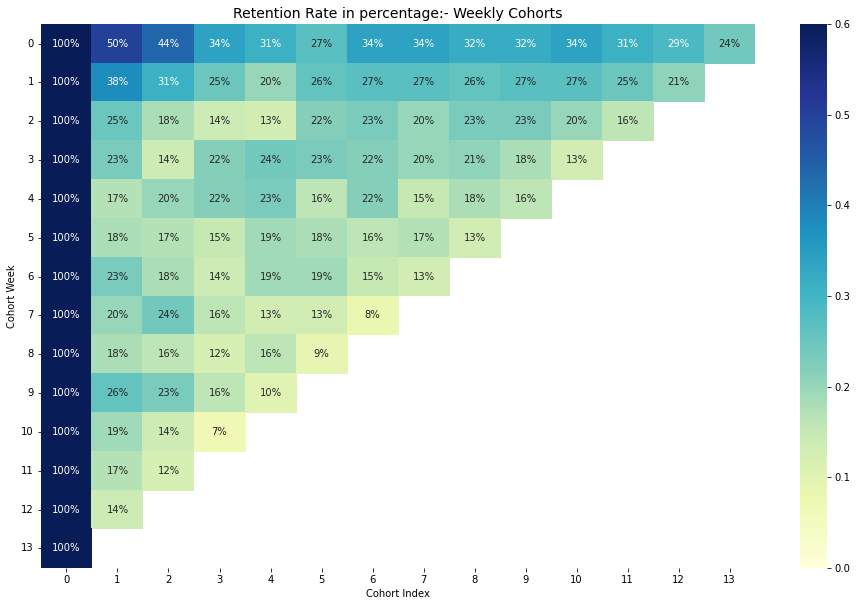

In [20]:
Tran_Jan = Transaction.loc[Transaction['DATE']>='2022-01-01']
Tran_Jan['Tran_JanWeek'] = Tran_Jan['DATE'].dt.week
Tran_Jan['Tran_JanWeek'].replace(52,0,inplace=True)
grouping = Tran_Jan.groupby('User_id')['Tran_JanWeek'] 
Tran_Jan['CohortWeek'] = grouping.transform('min')
Tran_Jan['CohortIndex'] = Tran_Jan['Tran_JanWeek'] - Tran_Jan['CohortWeek']
grouping = Tran_Jan.groupby(['CohortWeek', 'CohortIndex'])
cohort_data = grouping['User_id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortWeek',
                                 columns ='CohortIndex',
                                 values = 'User_id')
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention = retention.round(2)
plt.figure(figsize=(16, 10))
plt.title('Retention Rate in percentage:- Weekly Cohorts', fontsize = 14)
sns.heatmap(retention, annot=True, fmt= '.0%',cmap='YlGnBu', vmin = 0.0 , vmax = 0.6)
plt.ylabel('Cohort Week')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')
plt.show()

Question 2.1: User retention and transaction behavior (Is there any trend?) since Loyalty program launched. Do you have any advice for the Marketing department in designing promotion campaigns to increase user retention's performance monthly?

Preprocess data

In [21]:
Tran_RFM = Transaction.groupby(by='User_id').agg({'GMV':'sum','Order_id':'nunique','DATE':'max'}).sort_values(by='GMV',ascending=False)
Tran_RFM.rename(columns={'DATE': 'Recency',
                         'Order_id': 'Frequency',
                         'GMV': 'MonetaryValue'}, inplace=True)

In [22]:
day = dt.datetime.strptime('2022-31-03','%Y-%d-%m')
date_diff = []
for date in Tran_RFM['Recency']:
    date_diff.append((day-date.to_pydatetime()).days)
Tran_RFM['Recency'] = date_diff

In [23]:
Tran_RFM.loc[Tran_RFM['Recency']<=30,'R_rank'] = 5
Tran_RFM.loc[(Tran_RFM['Recency']<=90)&(Tran_RFM['Recency']>30),'R_rank'] = 4
Tran_RFM.loc[(Tran_RFM['Recency']<=180)&(Tran_RFM['Recency']>90),'R_rank'] = 3
Tran_RFM.loc[(Tran_RFM['Recency']<=365)&(Tran_RFM['Recency']>180),'R_rank'] = 2
Tran_RFM.loc[Tran_RFM['Recency']>=365,'R_rank'] = 1

In [24]:
Tran_RFM.loc[Tran_RFM['Frequency']>=Tran_RFM['Frequency'].quantile(0.95),'F_rank'] = 5
Tran_RFM.loc[(Tran_RFM['Frequency']<Tran_RFM['Frequency'].quantile(0.95))&(Tran_RFM['Frequency']>=Tran_RFM['Frequency'].quantile(0.8)),'F_rank'] = 4
Tran_RFM.loc[(Tran_RFM['Frequency']<Tran_RFM['Frequency'].quantile(0.8))&(Tran_RFM['Frequency']>=Tran_RFM['Frequency'].quantile(0.7)),'F_rank'] = 3
Tran_RFM.loc[(Tran_RFM['Frequency']<Tran_RFM['Frequency'].quantile(0.7))&(Tran_RFM['Frequency']>=Tran_RFM['Frequency'].quantile(0.4)),'F_rank'] = 2
Tran_RFM.loc[Tran_RFM['Frequency']<Tran_RFM['Frequency'].quantile(0.4),'F_rank'] = 1

In [25]:
Tran_RFM.loc[Tran_RFM['MonetaryValue']>=Tran_RFM['MonetaryValue'].quantile(0.95),'M_rank'] = 5
Tran_RFM.loc[(Tran_RFM['MonetaryValue']<Tran_RFM['MonetaryValue'].quantile(0.95))&(Tran_RFM['MonetaryValue']>=Tran_RFM['MonetaryValue'].quantile(0.8)),'M_rank'] = 4
Tran_RFM.loc[(Tran_RFM['MonetaryValue']<Tran_RFM['MonetaryValue'].quantile(0.8))&(Tran_RFM['MonetaryValue']>=Tran_RFM['MonetaryValue'].quantile(0.7)),'M_rank'] = 3
Tran_RFM.loc[(Tran_RFM['MonetaryValue']<Tran_RFM['MonetaryValue'].quantile(0.7))&(Tran_RFM['MonetaryValue']>=Tran_RFM['MonetaryValue'].quantile(0.4)),'M_rank'] = 2
Tran_RFM.loc[Tran_RFM['MonetaryValue']<Tran_RFM['MonetaryValue'].quantile(0.4),'M_rank'] = 1

In [26]:
Tran_RFM['RFM_Score'] = Tran_RFM['R_rank']+Tran_RFM['F_rank']+Tran_RFM['M_rank']
Tran_RFM = Tran_RFM.sort_values(by=['RFM_Score'],ascending=False).reset_index()

In [27]:
Tran_RFM["Customer_segment"] = np.where(Tran_RFM['RFM_Score'] >=
                                      11, "High value Customer",
                                      (np.where(
                                        Tran_RFM['RFM_Score'] >= 7,
                                        "Medium value Customer",
                                        'Low value Customer')))

In [28]:
Tran_RFM.head()

,User_id,MonetaryValue,Frequency,Recency,R_rank,F_rank,M_rank,RFM_Score,Customer_segment
0,54960619,176206775,291,2,5.0,5.0,5.0,15.0,High value Customer
1,35056426,8262062,38,14,5.0,5.0,5.0,15.0,High value Customer
2,51489581,8152249,57,13,5.0,5.0,5.0,15.0,High value Customer
3,27147134,8146803,70,16,5.0,5.0,5.0,15.0,High value Customer
4,13637611,8126994,48,30,5.0,5.0,5.0,15.0,High value Customer


<ipython-input-29-e417878e79c5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_rate["churn_label"] = pd.Series(


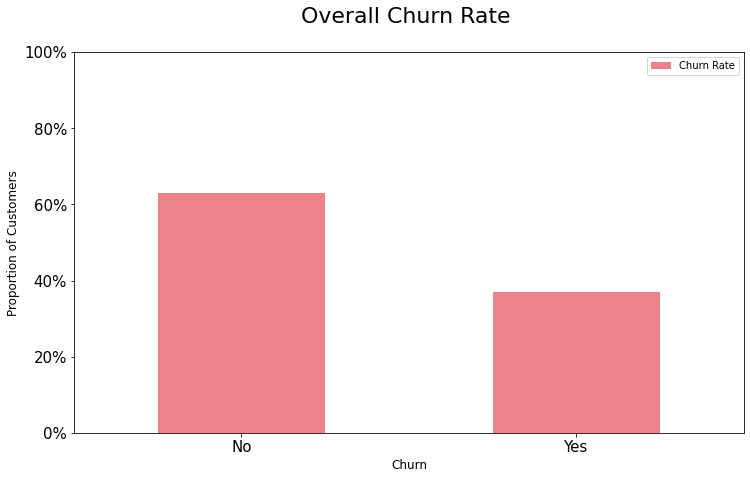

In [29]:
import matplotlib.ticker as mtick
churn_rate = Tran_RFM[["Recency", "User_id"]]
churn_rate["churn_label"] = pd.Series(
np.where((Tran_RFM['Recency']<120), "No", "Yes"))
sectors = churn_rate .groupby ("churn_label")
churn_rate = pd.DataFrame(sectors["User_id"].count())
churn_rate ["Churn Rate"] = (churn_rate ["User_id"]/ sum(churn_rate ["User_id"]) )*100
ax =  churn_rate[["Churn Rate"]].plot.bar(title = 'Overall Churn Rate',legend =True, table = False,grid = False,  subplots = False, 
figsize =(12, 7), color = '#ec838a', fontsize = 15, stacked=False, 
ylim =(0,100))

plt.ylabel('Proportion of Customers',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Churn',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")

plt.title('Overall Churn Rate \n',horizontalalignment="center", 
fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")

plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

I indicate churned customer as who have do a transaction within 120 days (about 4 months). According to the chart, the churn rate is about 40%, a quite significant number. In the following part I will try to find out what kind of customer churned the most.

In [30]:
#Get the transactions of churned customers
Churn_tran = pd.merge(Transaction,Tran_RFM[['User_id','Customer_segment']].loc[Tran_RFM['Recency']>=120],on='User_id')

In [31]:
#Find out the gap between their first and last transaction
Last_churn_tran = pd.DataFrame()
for x in Churn_tran['User_id'].unique():
    Last_churn_tran = Last_churn_tran.append(Churn_tran.loc[(Churn_tran['User_id']==x)&(Churn_tran['DATE'].loc[Churn_tran['User_id']==x]==Churn_tran['DATE'].loc[Churn_tran['User_id']==x].max())])

In [32]:
#Get it into the database
Churn_gap = pd.DataFrame(columns=['User_id','Churn_period'])
Churn_gap['User_id'] = Churn_tran['User_id'].unique()
for x in Churn_tran['User_id'].unique():
    first_tran = Transaction['DATE'].loc[Transaction['User_id']==x].min()
    last_tran = Churn_tran['DATE'].loc[(Churn_tran['User_id']==x)].max()
    gap = (last_tran-first_tran).days
    Churn_gap['Churn_period'].loc[Churn_gap['User_id']==x]=gap

c:\Users\Admin\AppData\Local\Programs\PythonCodingPack\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\Users\Admin\AppData\Local\Programs\PythonCodingPack\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\Users\Admin\AppData\Local\Programs\PythonCodingPack\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

<AxesSubplot:xlabel='Churn_period', ylabel='Count'>

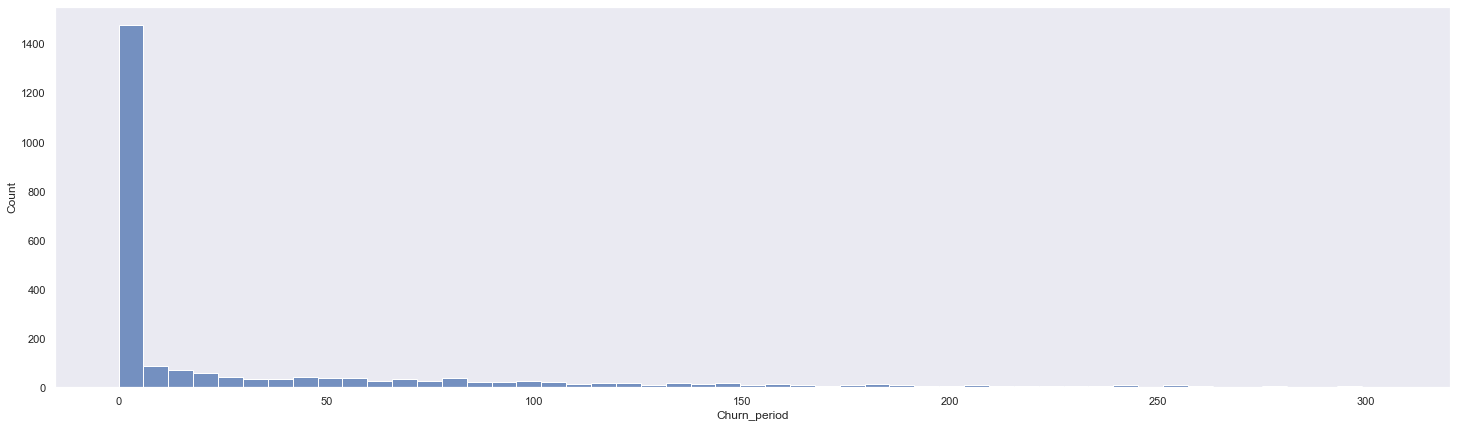

In [33]:
#Use histogram to visualize the time gap of churned customers
plt.figure(figsize=(25,7))
sns.set(style='dark')
sns.histplot(data=Churn_gap,x='Churn_period')

The chart shows that most of churned customers only do transaction in the first 5 days. It seem like they only use Momo one time. Let figure out why. 

In [34]:
#Encode the period 
Churn_gap['Churn Segment'] = ''
Churn_gap['Churn Segment'].loc[Churn_gap['Churn_period'].between(0,10)] = 0
Churn_gap['Churn Segment'].loc[Churn_gap['Churn_period'].between(10,30)] = 1
Churn_gap['Churn Segment'].loc[Churn_gap['Churn_period'].between(30,60)] = 2
Churn_gap['Churn Segment'].loc[Churn_gap['Churn_period'].between(60,90)] = 3
Churn_gap['Churn Segment'].loc[Churn_gap['Churn_period'].between(90,120)] = 4
Churn_gap['Churn Segment'].loc[Churn_gap['Churn_period'].between(120,150)] = 5
Churn_gap['Churn Segment'].loc[Churn_gap['Churn_period']>150]= 6

c:\Users\Admin\AppData\Local\Programs\PythonCodingPack\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [35]:
Churn_gap = pd.merge(Churn_gap[['User_id','Churn_period','Churn Segment']],Churn_tran[['User_id','Service Group','Customer_segment']].drop_duplicates(['User_id','Service Group'],keep='last'),on='User_id',how='left')

In [36]:
Churn_gap.head()

,User_id,Churn_period,Churn Segment,Service Group,Customer_segment
0,51426221,46,2,Coffee chains and Milk tea,Medium value Customer
1,11368352,16,1,data,Low value Customer
2,59720332,0,0,data,Low value Customer
3,49921027,148,5,supermarket,Low value Customer
4,49921027,148,5,data,Low value Customer


In [37]:
Churn_gap.groupby(['Churn Segment','Service Group'])['User_id'].count().unstack()

Service Group,Coffee chains and Milk tea,cvs,data,marketplace,supermarket
Churn Segment,,,,,
0,26,112,922,418,87
1,2,20,134,68,14
2,5,25,108,71,19
3,3,25,103,51,9
4,2,20,68,42,13
5,9,15,43,34,17
6,14,36,90,68,23


<AxesSubplot:xlabel='Churn Segment'>

<Figure size 1800x504 with 0 Axes>

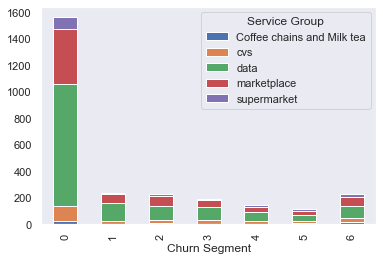

In [38]:
sns.set(style='dark')
plt.figure(figsize=(25,7))
Churn_gap.groupby(['Churn Segment','Service Group'])['User_id'].count().unstack().plot(kind='bar',stacked=True)

Most of churned customer doing transaction in data and marketplace group. I believe that because they only use Momo for the discount. Momo sometime has discount for mobile data and supermarket, so they only use it when there are a good deal. So my advice will be increase the rate of discount offers. 

Question 2.2: Momo is facing increasing amount of cashback cost as well as  GMV since launched. However, we want to optimize the cost but still want to keep growth of GMV and increase the retention rate.  Based on data given, please propose ideas to change the schemes of Loyalty benefits and Loyalty Points to alleviate the cost amount.

In [39]:
Transaction['YearMonth'] = pd.to_datetime(Transaction['DATE']).dt.strftime('%Y-%m')

(array([0, 1, 2]),
 [Text(0, 0, '2022-01'), Text(1, 0, '2022-02'), Text(2, 0, '2022-03')])

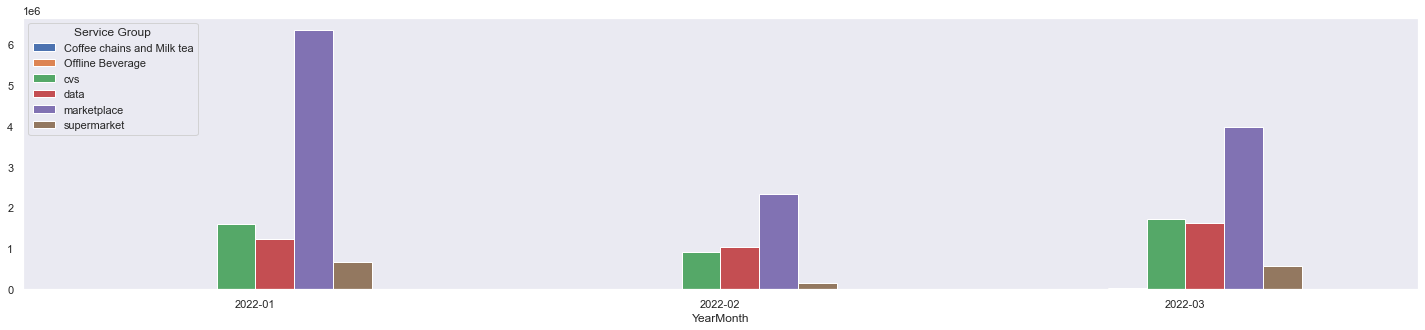

In [40]:
plt.rcParams["figure.figsize"] = (25,5)
Transaction[Transaction['DATE']>='2022-01-01'].groupby(['YearMonth','Service Group'])['%cashback'].sum().unstack().plot(kind='bar')
plt.xticks(rotation=0, horizontalalignment="center")

The highest amount of cashback belong to marketplace category.

In [41]:
Transaction = pd.merge(Transaction,Loyalty_ranking[['User_id','DATE','Class ID']],on=['User_id','DATE'])

<AxesSubplot:xlabel='%cashback', ylabel='Count'>

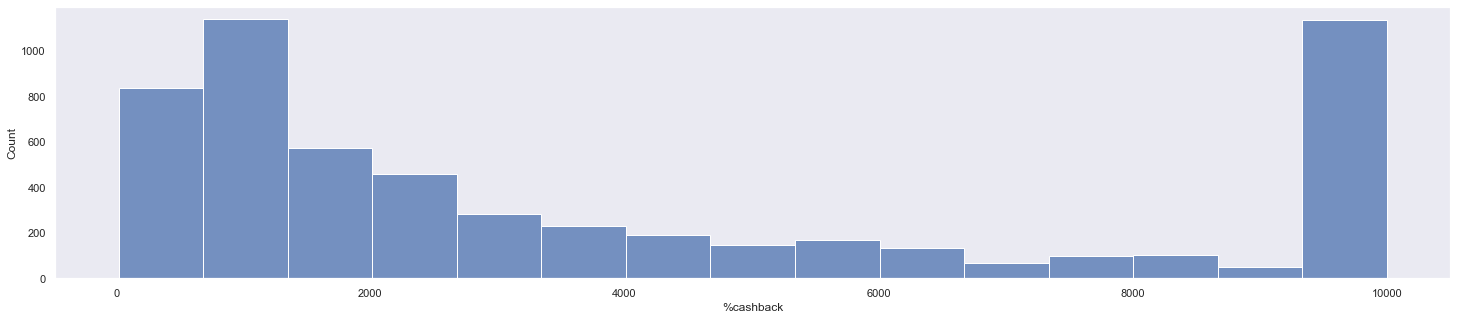

In [42]:
sns.histplot(data=Transaction[Transaction['%cashback']>0],x='%cashback')

There are a lot of cashback that exceed 10000 VND. 

<AxesSubplot:xlabel='%cashback', ylabel='Count'>

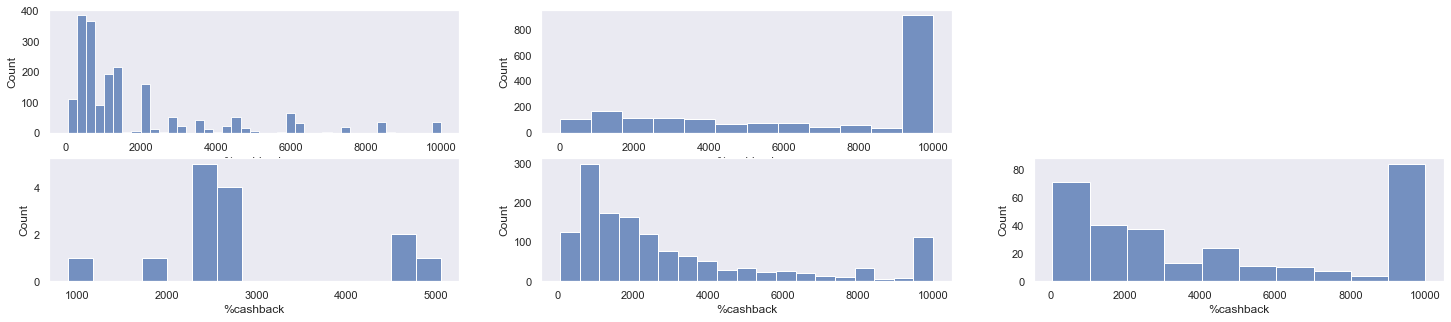

In [43]:
plt.subplot(2,3,1)
sns.histplot(data=Transaction[(Transaction['Service Group']=='data')&(Transaction['%cashback']>0)],x='%cashback')

plt.subplot(2,3,2)
sns.histplot(data=Transaction[(Transaction['Service Group']=='marketplace')&(Transaction['%cashback']>0)],x='%cashback')

plt.subplot(2,3,4)
sns.histplot(data=Transaction[(Transaction['Service Group']=='Offline Beverage')&(Transaction['%cashback']>0)],x='%cashback')

plt.subplot(2,3,5)
sns.histplot(data=Transaction[(Transaction['Service Group']=='cvs')&(Transaction['%cashback']>0)],x='%cashback')

plt.subplot(2,3,6)
sns.histplot(data=Transaction[(Transaction['Service Group']=='supermarket')&(Transaction['%cashback']>0)],x='%cashback')


The most amount of over-10000 cashback is in marketplace and supermarket catergory

<AxesSubplot:xlabel='GMV', ylabel='Count'>

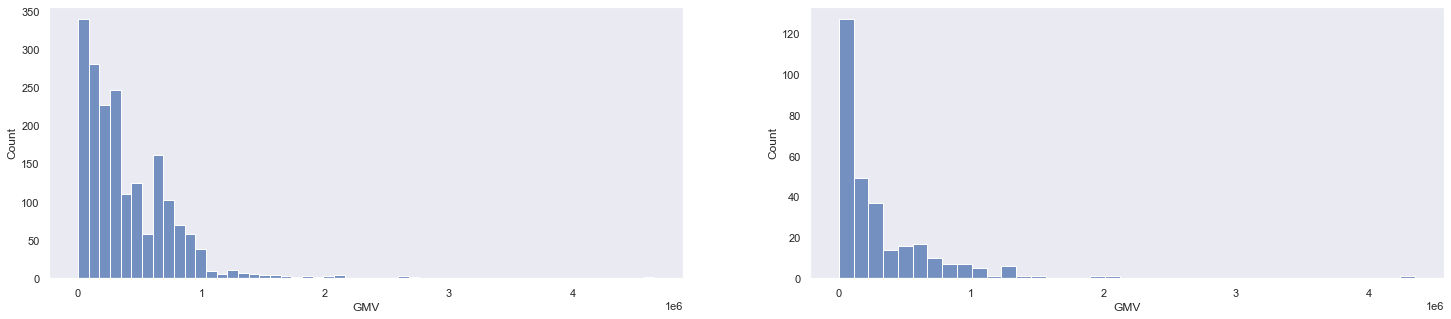

In [44]:
plt.subplot(1,2,1)
sns.histplot(data=Transaction[(Transaction['Service Group']=='marketplace')&(Transaction['%cashback']>0)],x='GMV')

plt.subplot(1,2,2)
sns.histplot(data=Transaction[(Transaction['Service Group']=='supermarket')&(Transaction['%cashback']>0)],x='GMV')

The problem is that it is too easy to exceed the 10000 mark. Customer just need to spend 500.000 if they are rank 3 or 200.000 if rank 4. There are more than half of transaction reach that point. So it is reasonable to reduce the cashback percentage in those 2 groups. 

What ideas do you have for Momo in loyalty program development strategy?

<AxesSubplot:xlabel='GMV', ylabel='Count'>

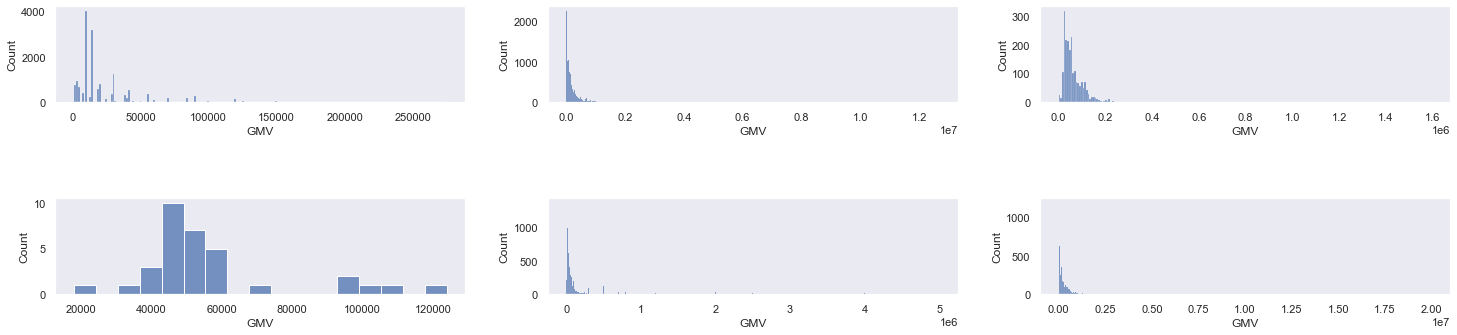

In [45]:
plt.subplot(2,3,1)
sns.histplot(data=Transaction[(Transaction['Service Group']=='data')&(Transaction['GMV']>0)],x='GMV')
plt.subplots_adjust(left  = 0.125,right = 0.9 ,bottom = 0.1,top = 0.9  ,wspace = 0.2 ,hspace = 1)

plt.subplot(2,3,2)
sns.histplot(data=Transaction[(Transaction['Service Group']=='marketplace')&(Transaction['GMV']>0)],x='GMV')
plt.subplots_adjust(left  = 0.125,right = 0.9 ,bottom = 0.1,top = 0.9  ,wspace = 0.2 ,hspace = 1)


plt.subplot(2,3,3)
sns.histplot(data=Transaction[(Transaction['Service Group']=='Coffee chains and Milk tea')&(Transaction['GMV']>0)],x='GMV')

plt.subplot(2,3,4)
sns.histplot(data=Transaction[(Transaction['Service Group']=='Offline Beverage')&(Transaction['GMV']>0)],x='GMV')

plt.subplot(2,3,5)
sns.histplot(data=Transaction[(Transaction['Service Group']=='cvs')&(Transaction['GMV']>0)],x='GMV')

plt.subplot(2,3,6)
sns.histplot(data=Transaction[(Transaction['Service Group']=='supermarket')&(Transaction['GMV']>0)],x='GMV')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, '2021-01'),
  Text(1, 0, '2021-02'),
  Text(2, 0, '2021-03'),
  Text(3, 0, '2021-04'),
  Text(4, 0, '2021-05'),
  Text(5, 0, '2021-06'),
  Text(6, 0, '2021-07'),
  Text(7, 0, '2021-08'),
  Text(8, 0, '2021-09'),
  Text(9, 0, '2021-10'),
  Text(10, 0, '2021-11'),
  Text(11, 0, '2021-12'),
  Text(12, 0, '2022-01'),
  Text(13, 0, '2022-02'),
  Text(14, 0, '2022-03')])

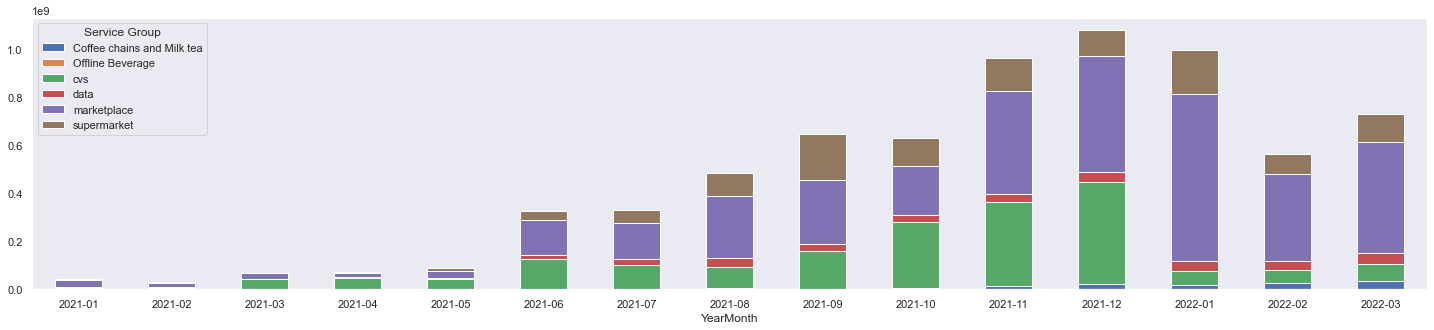

In [46]:
Transaction.groupby(by=['YearMonth','Service Group'])['GMV'].sum().unstack().plot(kind='bar',stacked=True)
plt.xticks(rotation=0, horizontalalignment="center")

[Text(0, 0, 'Coffee chains and Milk tea'),
 Text(1, 0, 'Offline Beverage'),
 Text(2, 0, 'cvs'),
 Text(3, 0, 'data'),
 Text(4, 0, 'marketplace'),
 Text(5, 0, 'supermarket')]

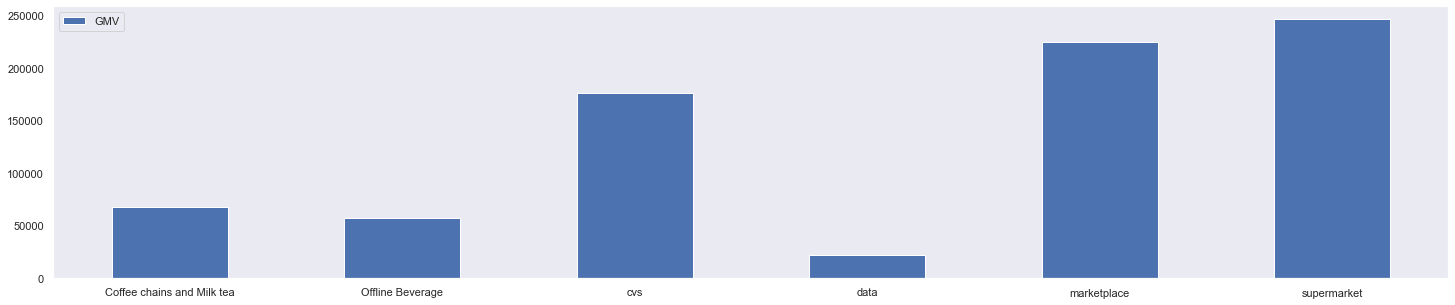

In [47]:
ax = Transaction.groupby(by=['Service Group'])['GMV'].mean().reset_index().plot(kind='bar')
plt.xticks(rotation=0, horizontalalignment="center")
labels = Transaction['Service Group'].sort_values().unique()
ax.set_xticklabels(labels)

[Text(0, 0, 'Coffee chains and Milk tea'),
 Text(1, 0, 'Offline Beverage'),
 Text(2, 0, 'cvs'),
 Text(3, 0, 'data'),
 Text(4, 0, 'marketplace'),
 Text(5, 0, 'supermarket')]

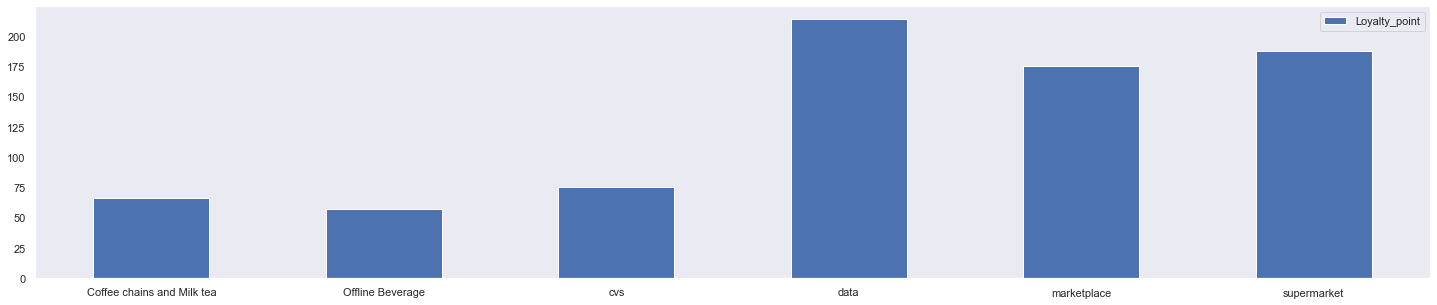

In [48]:
ax = Transaction.groupby(by=['Service Group'])['Loyalty_point'].mean().reset_index().plot(kind='bar')
plt.xticks(rotation=0, horizontalalignment="center")
labels = Transaction['Service Group'].sort_values().unique()
ax.set_xticklabels(labels)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, '2021-01'),
  Text(1, 0, '2021-02'),
  Text(2, 0, '2021-03'),
  Text(3, 0, '2021-04'),
  Text(4, 0, '2021-05'),
  Text(5, 0, '2021-06'),
  Text(6, 0, '2021-07'),
  Text(7, 0, '2021-08'),
  Text(8, 0, '2021-09'),
  Text(9, 0, '2021-10'),
  Text(10, 0, '2021-11'),
  Text(11, 0, '2021-12'),
  Text(12, 0, '2022-01'),
  Text(13, 0, '2022-02'),
  Text(14, 0, '2022-03')])

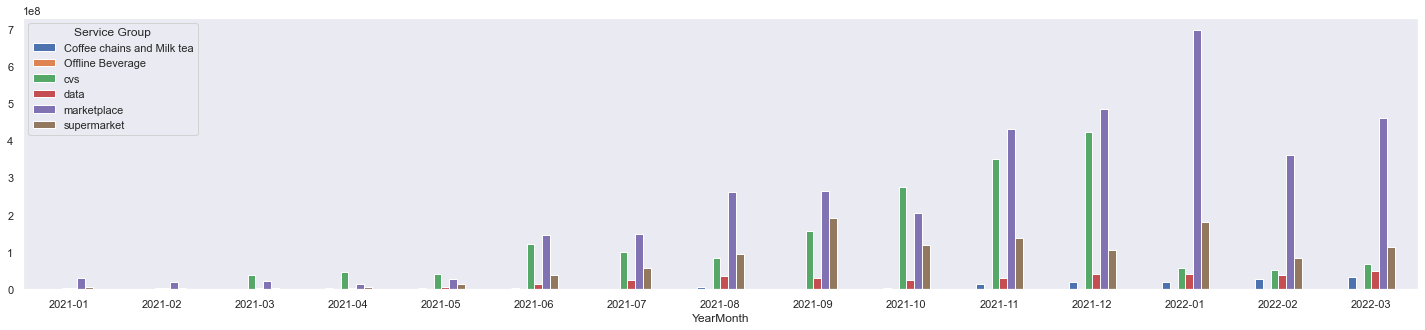

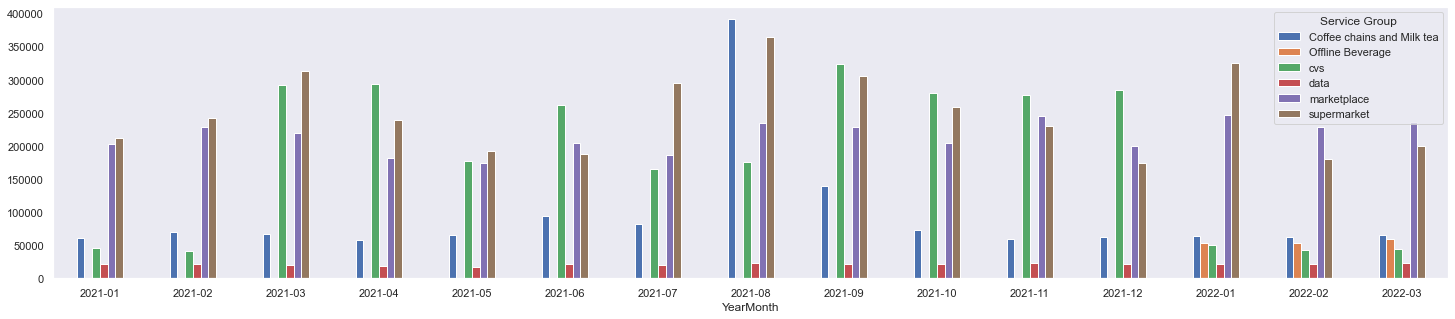

In [49]:
Transaction.groupby(by=['YearMonth','Service Group'])['GMV'].sum().unstack().plot(kind='bar')
plt.xticks(rotation=0, horizontalalignment="center")

Transaction.groupby(by=['YearMonth','Service Group'])['GMV'].mean().unstack().plot(kind='bar')
plt.xticks(rotation=0, horizontalalignment="center")

<AxesSubplot:xlabel='Loyalty_point', ylabel='Count'>

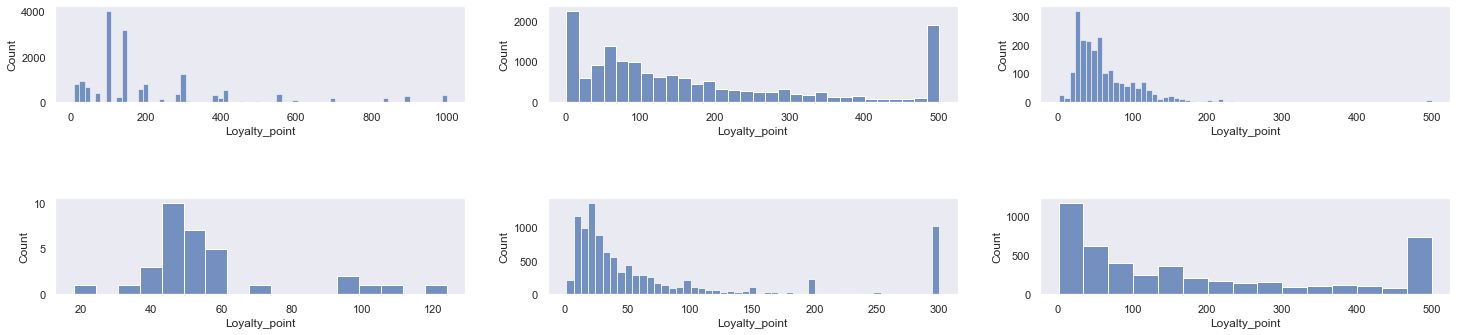

In [50]:
plt.subplot(2,3,1)
sns.histplot(data=Transaction[(Transaction['Service Group']=='data')&(Transaction['Loyalty_point']>0)],x='Loyalty_point')
plt.subplots_adjust(left  = 0.125,right = 0.9 ,bottom = 0.1,top = 0.9  ,wspace = 0.2 ,hspace = 1)

plt.subplot(2,3,2)
sns.histplot(data=Transaction[(Transaction['Service Group']=='marketplace')&(Transaction['Loyalty_point']>0)],x='Loyalty_point')
plt.subplots_adjust(left  = 0.125,right = 0.9 ,bottom = 0.1,top = 0.9  ,wspace = 0.2 ,hspace = 1)


plt.subplot(2,3,3)
sns.histplot(data=Transaction[(Transaction['Service Group']=='Coffee chains and Milk tea')&(Transaction['Loyalty_point']>0)],x='Loyalty_point')

plt.subplot(2,3,4)
sns.histplot(data=Transaction[(Transaction['Service Group']=='Offline Beverage')&(Transaction['Loyalty_point']>0)],x='Loyalty_point')

plt.subplot(2,3,5)
sns.histplot(data=Transaction[(Transaction['Service Group']=='cvs')&(Transaction['Loyalty_point']>0)],x='Loyalty_point')

plt.subplot(2,3,6)
sns.histplot(data=Transaction[(Transaction['Service Group']=='supermarket')&(Transaction['Loyalty_point']>0)],x='Loyalty_point')

Group data does not need that high of a loyalty point cap. Most of the transaction does not reach close to it despite having the highest ratio in point mechanism. Moreover, the average point user in data category earned on average is much higher than the average money the spent. So we should reduce the point mechanism to 0.001. 
CVS category has a pretty high average GMV but a very low amount of point earned. The reason is that a very high number of transaction exceed the 300-point-cap. So i think we should increase the point cap to 500. 

<AxesSubplot:xlabel='Raw_Loyalty_point', ylabel='Count'>

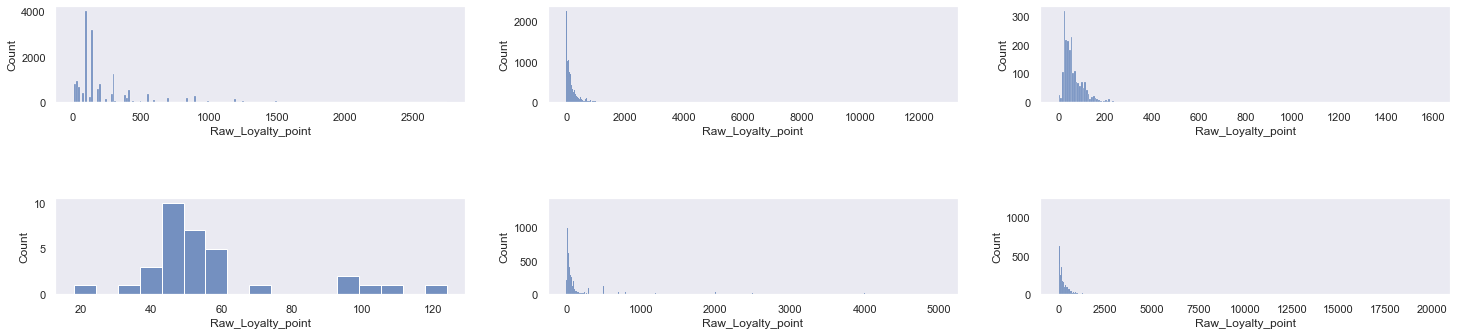

In [51]:
plt.subplot(2,3,1)
sns.histplot(data=Transaction[(Transaction['Service Group']=='data')&(Transaction['Raw_Loyalty_point']>0)],x='Raw_Loyalty_point')
plt.subplots_adjust(left  = 0.125,right = 0.9 ,bottom = 0.1,top = 0.9  ,wspace = 0.2 ,hspace = 1)

plt.subplot(2,3,2)
sns.histplot(data=Transaction[(Transaction['Service Group']=='marketplace')&(Transaction['Raw_Loyalty_point']>0)],x='Raw_Loyalty_point')
plt.subplots_adjust(left  = 0.125,right = 0.9 ,bottom = 0.1,top = 0.9  ,wspace = 0.2 ,hspace = 1)


plt.subplot(2,3,3)
sns.histplot(data=Transaction[(Transaction['Service Group']=='Coffee chains and Milk tea')&(Transaction['Raw_Loyalty_point']>0)],x='Raw_Loyalty_point')

plt.subplot(2,3,4)
sns.histplot(data=Transaction[(Transaction['Service Group']=='Offline Beverage')&(Transaction['Raw_Loyalty_point']>0)],x='Raw_Loyalty_point')

plt.subplot(2,3,5)
sns.histplot(data=Transaction[(Transaction['Service Group']=='cvs')&(Transaction['Raw_Loyalty_point']>0)],x='Raw_Loyalty_point')

plt.subplot(2,3,6)
sns.histplot(data=Transaction[(Transaction['Service Group']=='supermarket')&(Transaction['Raw_Loyalty_point']>0)],x='Raw_Loyalty_point')

Question 3.2: Gamification is usually a sensible option for apps to raise users’ stickiness. In our loyalty program development strategy, we also plan to hold a small game for users. The rule is simple: any users who can maintain a 20-day or longer streak of being in the DIAMOND ranking is a winner (in other words, winners are users who have total loyalty points greater than or equal to 5,000 for at least 20 consecutive days). We also want to give a special reward for the user(s) who can maintain the longest streak. Could you help us to calculate how many winners were there during the last thirty days in the given data (March 01 - March 31) and who was/were the one(s) boasting the longest streak during that time?

In [ ]:
Diamond_in_march = Loyalty_ranking.loc[(Loyalty_ranking['DATE']>='2022-03-01')&(Loyalty_ranking['DATE']<='2022-03-31')&(Loyalty_ranking['Rank_name']=='Diamond')]

In [ ]:
n=0
for x in Diamond_in_march['User_id'].unique():
    a = Diamond_in_march[['DATE','Rank_name']].loc[Diamond_in_march['User_id']==x]
    s = (a.Rank_name.ne('Diamond') | a.DATE.diff().dt.days.ne(1)).cumsum()
    out = a[a.Rank_name.eq('Diamond')].groupby(s).DATE.agg(['first','last','count'])
    if out['count'].max() >= 20:
        n=n+1
print(n)

8


There are 8 users having more than 20 days streak at Diamond

In [ ]:
streak=pd.DataFrame()
for x in Diamond_in_march['User_id'].unique():
    a = Diamond_in_march[['DATE','Rank_name']].loc[Diamond_in_march['User_id']==x]
    s = (a.Rank_name.ne('Diamond') | a.DATE.diff().dt.days.ne(1)).cumsum()
    out = a[a.Rank_name.eq('Diamond')].groupby(s).DATE.agg(['first','last','count'])
    out['User_id'] = x
    streak = pd.concat([streak,out])
streak[streak['count']==streak['count'].max()]

,first,last,count,User_id
1,2022-03-01,2022-03-31,31,57207697
1,2022-03-01,2022-03-31,31,47662326


The longest streak is 31 days